
IN Linear Regression or so called OLS we assume the relationship between input Variable X and output variable Y can  be modeled as<br> $$Y = \theta_0 + \theta_1 X_1 + \theta_2 X_2 + .... + \epsilon $$
Loss Function : <br>
$$L = (y - \theta X)^2 $$
with Quantile regression we ahve an additional parameter $\tau$ which specifies the $\tau_{th}$ quantile of our target variable Y that we are interested in modeling where $\tau\epsilon(0,1) $
$$\
L = \begin{cases}
\tau(y - X\theta), & \text{if } y - X\theta \geq 0 \\
(\tau - 1)(y - X\theta), & \text{if } y - X\theta < 0
\end{cases}
$$  

 The quantile loss differs depending on the evaluated quantile. Such that more negative errors are penalized more when we specify a higher quantiles and more positive errors are penalized more for lower quantiles.

In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor


In [ ]:
X, y = make_regression(n_samples = 10000,
                       n_features = 1,
                       n_informative = 1,
                       n_targets = 1,
                       random_state = 42)
Xs = pd.DataFrame(X, columns = ['distance'])
ys = pd.DataFrame(y, columns = ['time_to_buyer'])

Xs['distance'] = Xs['distance'].apply(lambda x: 10 + 2 *(x + np.random.normal(loc = 1)))
ys['time_to_buyer'] = ys['time_to_buyer'].apply(lambda x : 60 + 0.3 *(x + np.random.normal(loc = 1)))

In [ ]:
df  = Xs.merge(ys, left_index = True, right_index = True)

In [ ]:
df.describe()

,distance,time_to_buyer
count,10000.000000,10000.000000
mean,11.968267,60.284198
std,2.809565,9.674035
min,1.057590,22.512610
25%,10.093567,53.827777
50%,11.961119,60.310190
75%,13.809937,66.752606
max,22.437892,98.028398


In [ ]:
df.head()

,distance,time_to_buyer
0,10.524563,54.308208
1,12.259738,52.674178
2,12.521182,66.230792
3,13.749320,65.910529
4,17.737677,68.905149


In [ ]:
train_df, test_df = train_test_split(df, test_size = 0.1, shuffle = False)
X_train, y_train = train_df[['distance']], train_df[['time_to_buyer']]
X_test, y_test = test_df[['distance']], test_df[['time_to_buyer']]

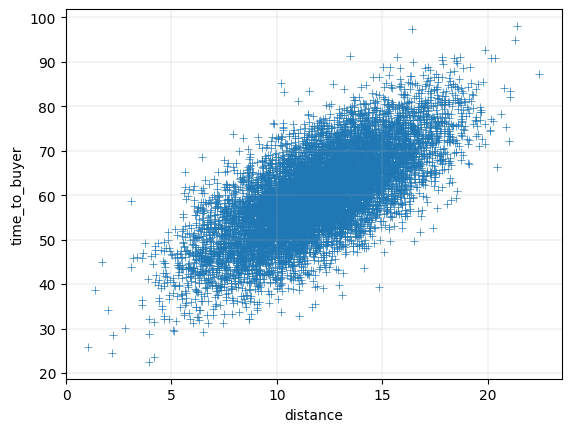

In [ ]:
plt.rcParams.update({'font.size':10, 'figure.dpi':100})
sns.scatterplot(data = df, x = 'distance', y = "time_to_buyer", marker = "+")
plt.grid(linestyle = '-', linewidth = 0.2)

In [ ]:
classifier = {}
for tau in [0.1, 0.5, 0.9]:
  clf = LGBMRegressor(objective = 'quantile', alpha = tau)
  clf.fit(X_train, y_train)
  preds = pd.DataFrame(clf.predict(X_test), columns = [str(tau)])
  classifier[str(tau)] = {'clf':clf, 'predictions':preds}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 1
[LightGBM] [Info] Start training from score 47.948746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 1
[LightGBM] [Info] Start training from score 60.319576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 1
[LightGBM] [Info] Start training f

In [ ]:
classifier

{'0.1': {'clf': LGBMRegressor(alpha=0.1, objective='quantile'),
  'predictions':            0.1
  0    45.760006
  1    53.588006
  2    43.611159
  3    51.542898
  4    56.778083
  ..         ...
  995  57.655661
  996  49.846602
  997  54.420669
  998  52.950868
  999  69.645840
  
  [1000 rows x 1 columns]},
 '0.5': {'clf': LGBMRegressor(alpha=0.5, objective='quantile'),
  'predictions':            0.5
  0    53.102680
  1    61.991964
  2    51.556362
  3    61.466619
  4    64.938753
  ..         ...
  995  66.446712
  996  59.772873
  997  63.591535
  998  59.563858
  999  80.385915
  
  [1000 rows x 1 columns]},
 '0.9': {'clf': LGBMRegressor(alpha=0.9, objective='quantile'),
  'predictions':            0.9
  0    61.704457
  1    69.216468
  2    60.321296
  3    67.354696
  4    74.755586
  ..         ...
  995  74.498123
  996  66.334362
  997  75.973119
  998  69.201349
  999  86.402927
  
  [1000 rows x 1 columns]}}

In [ ]:
classifier['0.1']['predictions']

,0.1
0,45.760006
1,53.588006
2,43.611159
3,51.542898
4,56.778083
...,...
995,57.655661
996,49.846602
997,54.420669
998,52.950868


In [ ]:
data = pd.DataFrame({'distance': X_test.reset_index()['distance'],
              '0.1': classifier['0.1']['predictions']['0.1'],
              '0.5': classifier['0.5']['predictions']['0.5'],
              '0.9': classifier['0.9']['predictions']['0.9'],
              'time_to_buyer': y_test.reset_index()['time_to_buyer']})

In [ ]:
data.sample(2)

,distance,0.1,0.5,0.9,time_to_buyer
612,12.814700,52.823767,60.051547,70.032867,73.884289
476,15.714187,61.365977,69.464600,76.581482,62.458060


In [ ]:
melted_data = pd.melt(data, id_vars=['distance'])
melted_data

,distance,variable,value
0,14.992241,0.1,56.781096
1,8.786426,0.1,42.661314
2,10.062553,0.1,43.796663
3,14.579266,0.1,58.317294
4,9.643379,0.1,44.645072
...,...,...,...
3995,12.500503,time_to_buyer,62.558969
3996,10.395419,time_to_buyer,59.759737
3997,16.138549,time_to_buyer,76.071071
3998,10.098389,time_to_buyer,54.056648


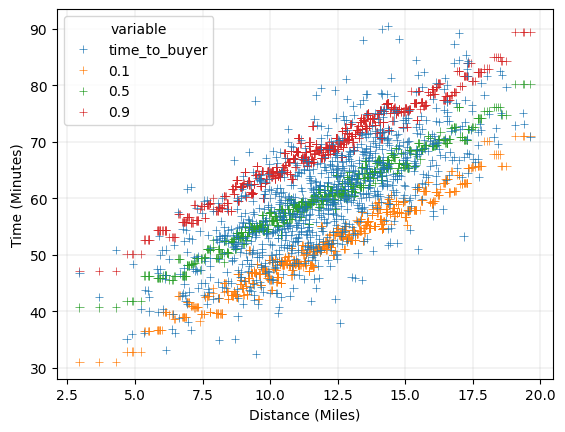

In [ ]:
plt.rcParams.update({'font.size': 10, 'figure.dpi':100})
sns.scatterplot(data=melted_data,
                x="distance",
                y='value',
                hue='variable',
                hue_order=['time_to_buyer', '0.1', '0.5', '0.9'],
                marker='+')
plt.grid(linestyle='-', linewidth=0.2)
ylabel = plt.ylabel("Time (Minutes)")
xlabel = plt.xlabel("Distance (Miles)")

In [ ]:
(data['time_to_buyer'] > data['0.1']).value_counts()

,count
True,894
False,106


The fact that time_to_buyer is greater than the 0.1 quantile prediction 894 times and less than or equal to it 106 times indicates that about 10.6% (106 out of 1000) of the actual values are below the predicted 10th percentile, which is close to the expected 10%.

In [ ]:
(data['time_to_buyer'] > data['0.5']).value_counts()

,count
False,516
True,484


This indicates that about 48.4% of the actual values are above the predicted median, which is close to the expected 50%.

In [ ]:
(data['time_to_buyer'] > data['0.9']).value_counts()

,count
False,900
True,100


The fact that time_to_buyer is greater than the 0.9 quantile prediction 100 times and less than or equal to it 900 times indicates that about 10% of the actual values are above the predicted 90th percentile, which is exactly as expected.

In [70]:
def compute_quantile_loss(y_true, y_pred, quantile):
    """

    Parameters
    ----------
    y_true : 1d ndarray
        Target value.

    y_pred : 1d ndarray
        Predicted value.

    quantile : float, 0. ~ 1.
        Quantile to be evaluated, e.g., 0.5 for median.
    """
    residual = y_true - y_pred
    return np.maximum(quantile * residual, (quantile - 1) * residual)

In [ ]:
# Suppose we've made a prediction for a single point with a true value of zero,
# and our predictions range from -1 to +1 that is, our errors also range from -1 to +1.
n_samples = 1000
y_true = np.zeros(n_samples)
y_pred = np.linspace(-1, 1, n_samples)

quantiles = [0.1, 0.5, 0.9]
quantile_losses = [
    compute_quantile_loss(y_true, y_pred, quantile)
    for quantile in quantiles
]

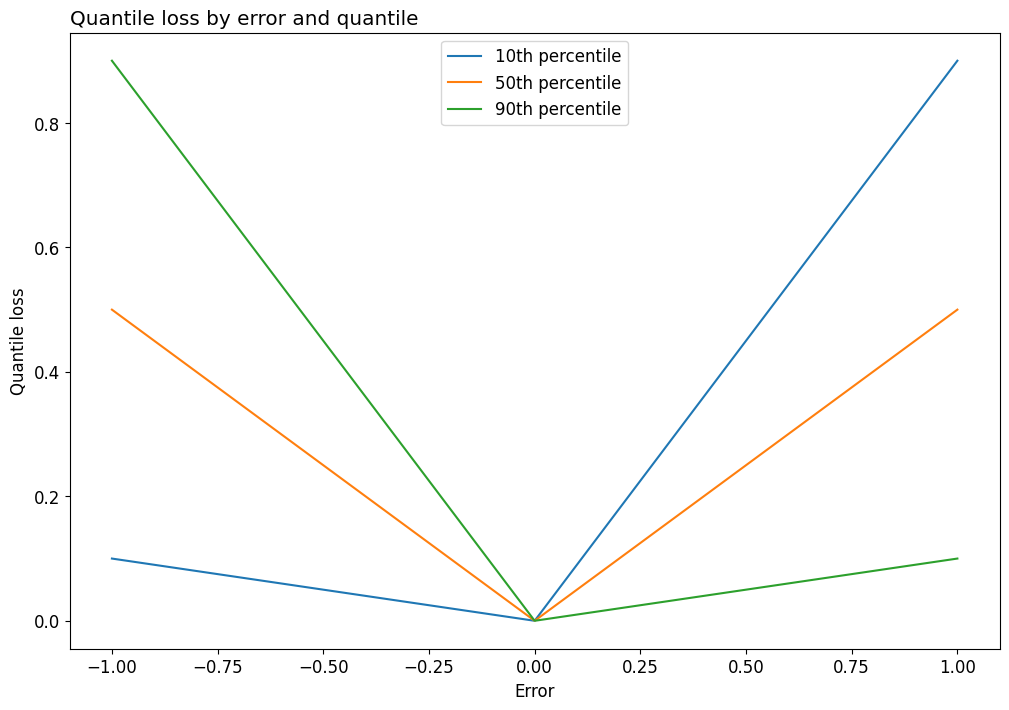

In [ ]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 12


for quantile_loss in quantile_losses:
    plt.plot(y_pred, quantile_loss)

plt.legend([str(int(q * 100)) + 'th percentile' for q in quantiles])
plt.xlabel('Error')
plt.ylabel('Quantile loss')
plt.title('Quantile loss by error and quantile', loc='left')
plt.show()



Let's look at each line separately:

1. The orange line shows the median, which,is symmetric around zero. The median aims to bisect the set of predictions, so we want to weigh underestimates equally to overestimates. As it turns out choosing a quantile of 0.5 is equivalent to modeling the absolute values of the residuals $∣(y−X\theta)∣$.

2. The blue line shows the 10th percentile, which assigns a lower loss to negative errors and a higher loss to positive errors. The 10th percentile means we think there's a 10 percent chance that the true value is below the predicted value, so it makes sense to assign less weight to underestimates than to overestimates.
3. The green blue line shows the 90th percentile, which is the opposite of the 10th percentile.

In [60]:
def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)


def gen_data(low, high, n_samples, scale=4, test_size=0.2, random_state=3):
    """generate training and testing data from the ground truth function"""
    np.random.seed(15)
    X = np.random.uniform(low, high, size=n_samples)

    # generate the response from the ground truth function and add
    # some random noise to it, scale controls the variance of the noise.
    y = ground_truth(X) + np.random.normal(scale=scale, size=n_samples)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test


def plot_data(x_plot, X_train, X_test, y_train, y_test, low, high):
    """plot training and testing data"""
    s = 15
    plt.plot(x_plot, ground_truth(x_plot), alpha=0.5, label='ground truth')
    plt.scatter(X_train, y_train, s=s, alpha=0.2,color = 'yellow')
    plt.scatter(X_test, y_test, s=s, alpha=0.2, color='blue')
    plt.xlim((low, high))
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(loc='upper left')
    plt.show()

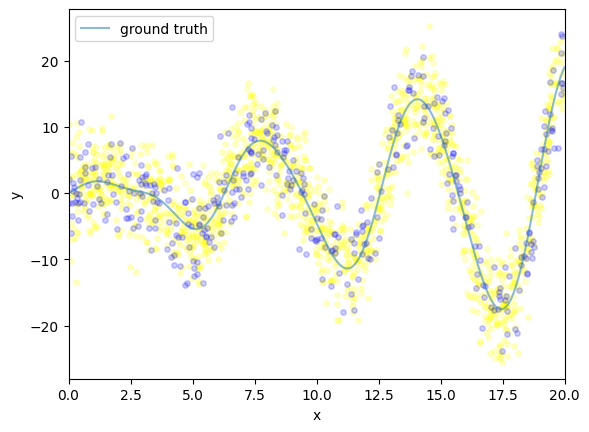

In [62]:
low = 0
high = 20
x_plot = np.linspace(low, high, 500)

n_samples = 2000
X_train, X_test, y_train, y_test = gen_data(low=low, high=high, n_samples=n_samples)

plot_data(x_plot, X_train, X_test, y_train, y_test, low, high)

In [63]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20]
}

# Initialize the LGBMRegressor
lgb_reg = LGBMRegressor(objective='regression')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lgb_reg, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train[:, np.newaxis], y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Best estimator
best_lgb = grid_search.best_estimator_

# Fit the best estimator on the whole training data
best_lgb.fit(X_train[:, np.newaxis], y_train)

# Predictions
y_pred = best_lgb.predict(X_test[:, np.newaxis])

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 1
[LightGBM] [Info] Start training from score -0.196438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [64]:
best_lgb

LGBMRegressor(colsample_bytree=0.7, max_depth=5, n_estimators=50,
              objective='regression', subsample=0.7)

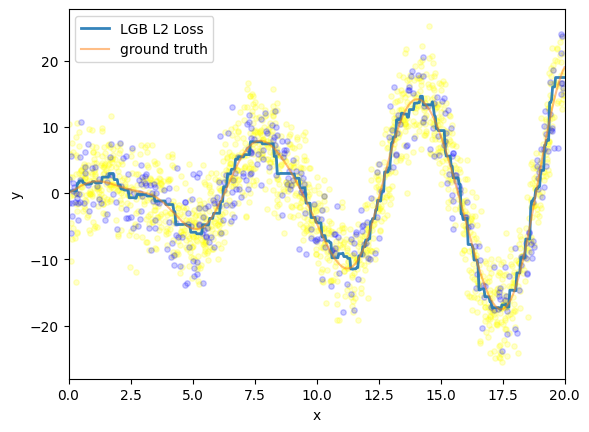

In [65]:
plt.plot(x_plot, best_lgb.predict(x_plot[:, np.newaxis]),label='LGB L2 Loss', alpha=0.9, linewidth=2)
plot_data(x_plot, X_train, X_test, y_train, y_test, low, high)

In [67]:
quantile_alphas = [0.1, 0.5, 0.9]

lgb_quantile_alphas = {}
for quantile_alpha in quantile_alphas:
    # to train a quantile regression, we change the objective parameter and
    # specify the quantile value we're interested in
    lgb = LGBMRegressor(objective='quantile', alpha=quantile_alpha)
    lgb.fit(X_train[:, np.newaxis], y_train)
    lgb_quantile_alphas[quantile_alpha] = lgb

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 1
[LightGBM] [Info] Start training from score -12.357257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

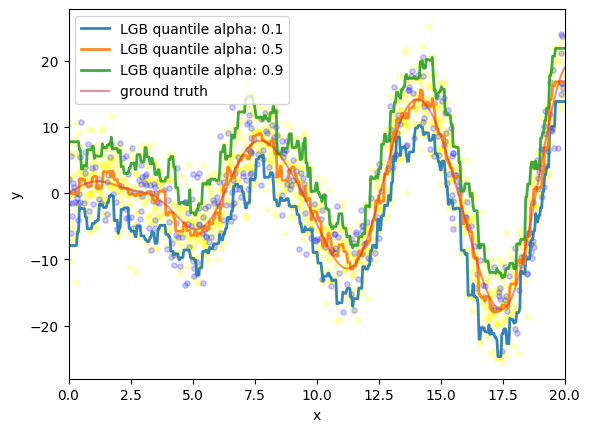

In [68]:
for quantile_alpha, lgb in lgb_quantile_alphas.items():
    plt.plot(x_plot, lgb.predict(x_plot[:, np.newaxis]),
             label='LGB quantile alpha: {}'.format(quantile_alpha),
             alpha=0.9, linewidth=2)

plot_data(x_plot, X_train, X_test, y_train, y_test, low, high)

In [71]:
def create_loss_comparision():
    model_name = []
    columns = []
    results = []

    y_true = ground_truth(x_plot[:, np.newaxis])
    for quantile_alpha, lgb in lgb_quantile_alphas.items():
        quantile_str = str(int(quantile_alpha * 100))
        columns.append('quantile_' + quantile_str)
        model_name.append('lgb_' + quantile_str)

        y_pred = lgb.predict(x_plot[:, np.newaxis])
        result = [
            compute_quantile_loss(y_true, y_pred, quantile).mean()
            for quantile in quantile_alphas
        ]
        results.append(result)


    df_results = pd.DataFrame(results, columns=columns)
    df_results['model'] = model_name
    return df_results


df_results = create_loss_comparision()
df_results

,quantile_10,quantile_50,quantile_90,model
0,3.090810,5.058064,7.025318,lgb_10
1,4.557333,4.559724,4.562115,lgb_50
2,6.996769,5.031321,3.065873,lgb_90


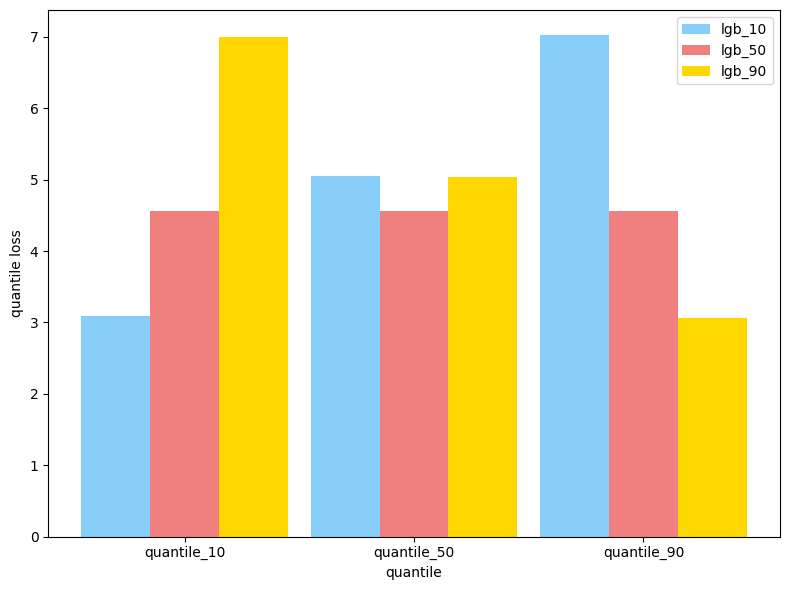

In [72]:
def score_barplot(df_results, model_col='model', figsize=(8, 6)):
    metrics_cols = ['quantile_10', 'quantile_50', 'quantile_90']
    colors = ['lightskyblue', 'lightcoral', 'gold']

    width = 0.3
    ind = np.arange(len(metrics_cols))

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    n_rows = df_results.shape[0]
    for i in range(n_rows):
        x = ind + (i * width)
        height = df_results.loc[i, metrics_cols]
        label = df_results.loc[i, model_col]
        ax.bar(x, height, width, label=label, color=colors[i])

    half_width = (n_rows // 2) * width
    ax.set_xticks(ind + half_width)
    ax.set_xticklabels(metrics_cols)
    ax.set_ylabel('quantile loss')
    ax.set_xlabel('quantile')
    ax.legend()
    plt.tight_layout()
    plt.show()
score_barplot(df_results)

1. lgb_10 This model performs best in predicting the 10th percentile compared to the other percentiles
2. lgb_50 This model performs similarly across different percentiles but is focused on predicting the median (50th percentile) effectively.
3. lgb_90 This model performs best in predicting the 90th percentile compared to the other percentiles.